The chosen modeling has two aspects:
- a primary model, whose goal is to predict matches final issue (home, away or draw)
- secondary models, whose goals are to predict the number of goals scored by home and away teams knowing the match final issue

This notebooks focuses on the primary model, and has the following sections:
- feature engineering
- feature selection
- fitting
- model evaluation

DIRE QUON FAIT AUSSI DU SECONDARY MODEL

In [7]:
import pandas as pd
import numpy as np
import optuna
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_path)

from src.config import load_config
from src.feature_engineering import create_diff_features
from src.feature_selection import find_highly_correlated_cols, remove_low_variance_features, select_top_features
from src.modeling import run_grid_searches, load_model, evaluate_model_metrics

# config.yaml importation
config_file = 'config.yaml'
config_path = os.path.join(root_path, config_file)
config = load_config(config_path)

# Preprocessed data importation

In [8]:
preprocessed_data_path = os.path.join(root_path, config['preprocessed_dir'])
df_train_path = os.path.join(preprocessed_data_path, f"{config['preprocessed_train_df_name']}.csv")
df_test_path = os.path.join(preprocessed_data_path, f"{config['preprocessed_test_df_name']}.csv")

df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)
df_train.head()

,date,season,home,away,nb_goals_home,nb_goals_away,final_result,odd_home,odd_away,odd_draw,...,strict_rel_recent_nb_goals_conceded_by_match_home_team,strict_rel_recent_nb_goals_conceded_by_match_away_team,strict_rel_recent_goal_difference_home_team,strict_rel_recent_goal_difference_away_team,strict_rel_recent_percentage_victory_home_team,strict_rel_recent_percentage_victory_away_team,hist_nb_seasons_l1_home_team,hist_nb_seasons_l1_away_team,promoted_home_team,promoted_away_team
0,2010-08-07,2010/2011,Auxerre,Lorient,2,2,draw,2.062182,4.471373,3.374938,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0
1,2010-08-07,2010/2011,Lens,Nancy,1,2,away,2.209682,3.958873,3.299938,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0
2,2010-08-07,2010/2011,Lyon,Monaco,0,0,draw,1.732182,7.208873,3.999938,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0
3,2010-08-07,2010/2011,Marseille,Caen,1,2,away,1.597182,9.146373,5.299938,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0
4,2010-08-07,2010/2011,Nice,Valenciennes,0,0,draw,2.234682,3.833873,3.324938,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0


In [9]:
primary_target = config['final_result_column']
secondary_target_home = config['nb_goals_home_column']
secondary_target_away = config['nb_goals_away_column']

X_train = df_train.drop(columns=[primary_target, secondary_target_home, secondary_target_away, config['date_column'], config['season_column']])
X_test = df_test.drop(columns=[primary_target, secondary_target_home, secondary_target_away, config['date_column'], config['season_column']])

# Target for primary model
y_train_primary = df_train[primary_target]
y_test_primary = df_test[primary_target]

# Targets for secondary models
y_train_secondary_home = df_train[secondary_target_home]
y_test_secondary_home = df_test[secondary_target_home]

y_train_secondary_away = df_train[secondary_target_away]
y_test_secondary_away = df_test[secondary_target_away]

In [10]:
X_train.columns

Index(['home', 'away', 'odd_home', 'odd_away', 'odd_draw',
       'current_season_points_home_team', 'current_season_points_away_team',
       'current_season_general_ranking_home_team',
       'current_season_general_ranking_away_team',
       'current_season_nb_goals_scored_home_team',
       'current_season_nb_goals_scored_away_team',
       'current_season_nb_goals_conceded_home_team',
       'current_season_nb_goals_conceded_away_team',
       'current_season_goal_difference_home_team',
       'current_season_goal_difference_away_team',
       'current_season_attack_ranking_home_team',
       'current_season_attack_ranking_away_team',
       'current_season_defense_ranking_home_team',
       'current_season_defense_ranking_away_team',
       'current_season_nb_points_home_team_at_home',
       'current_season_nb_points_away_team_away',
       'current_season_home_team_ranking_at_home',
       'current_season_away_team_ranking_away',
       'current_season_nb_goals_scored_home_team

# Primary model

Target: issue of a match (home / draw / away).

## Feature engineering

Since we want to model the final issue of a match, exhaustive data related to home and away teams is not necessary. That is why for each pair of similar columns for home and away teams, we create the difference between these two columns.

In [11]:
patterns = [
        ("_home_team_ranking_at_home", "_away_team_ranking_away"),
        ("_home_team_at_home", "_away_team_away"),
        ("_home_team", "_away_team"),
        ("_at_home", "_away"),
        ("_home", "_away")
]

X_train_primary = create_diff_features(X_train, patterns=patterns)
X_test_primary = create_diff_features(X_test, patterns=patterns)

X_train_primary.head()

,home,away,odd_home,odd_away,odd_draw,diff_current_season,diff_current_season_nb_points,diff_current_season_nb_goals_scored,diff_current_season_nb_goals_conceded,diff_current_season_points,...,diff_rel_recent_nb_goals_conceded_by_match,diff_rel_recent_goal_difference,diff_rel_recent_percentage_victory,diff_strict_rel_recent_nb_points_by_match,diff_strict_rel_recent_nb_goals_scored_by_match,diff_strict_rel_recent_nb_goals_conceded_by_match,diff_strict_rel_recent_goal_difference,diff_strict_rel_recent_percentage_victory,diff_hist_nb_seasons_l1,diff_promoted
0,Auxerre,Lorient,2.062182,4.471373,3.374938,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,Lens,Nancy,2.209682,3.958873,3.299938,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,Lyon,Monaco,1.732182,7.208873,3.999938,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,Marseille,Caen,1.597182,9.146373,5.299938,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,Nice,Valenciennes,2.234682,3.833873,3.324938,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


## Feature Selection

We implemented 3 methods to select features:
- remove highly correlated features
- remove low variance features
- select top K features which could explain the primary target

### Correlation method

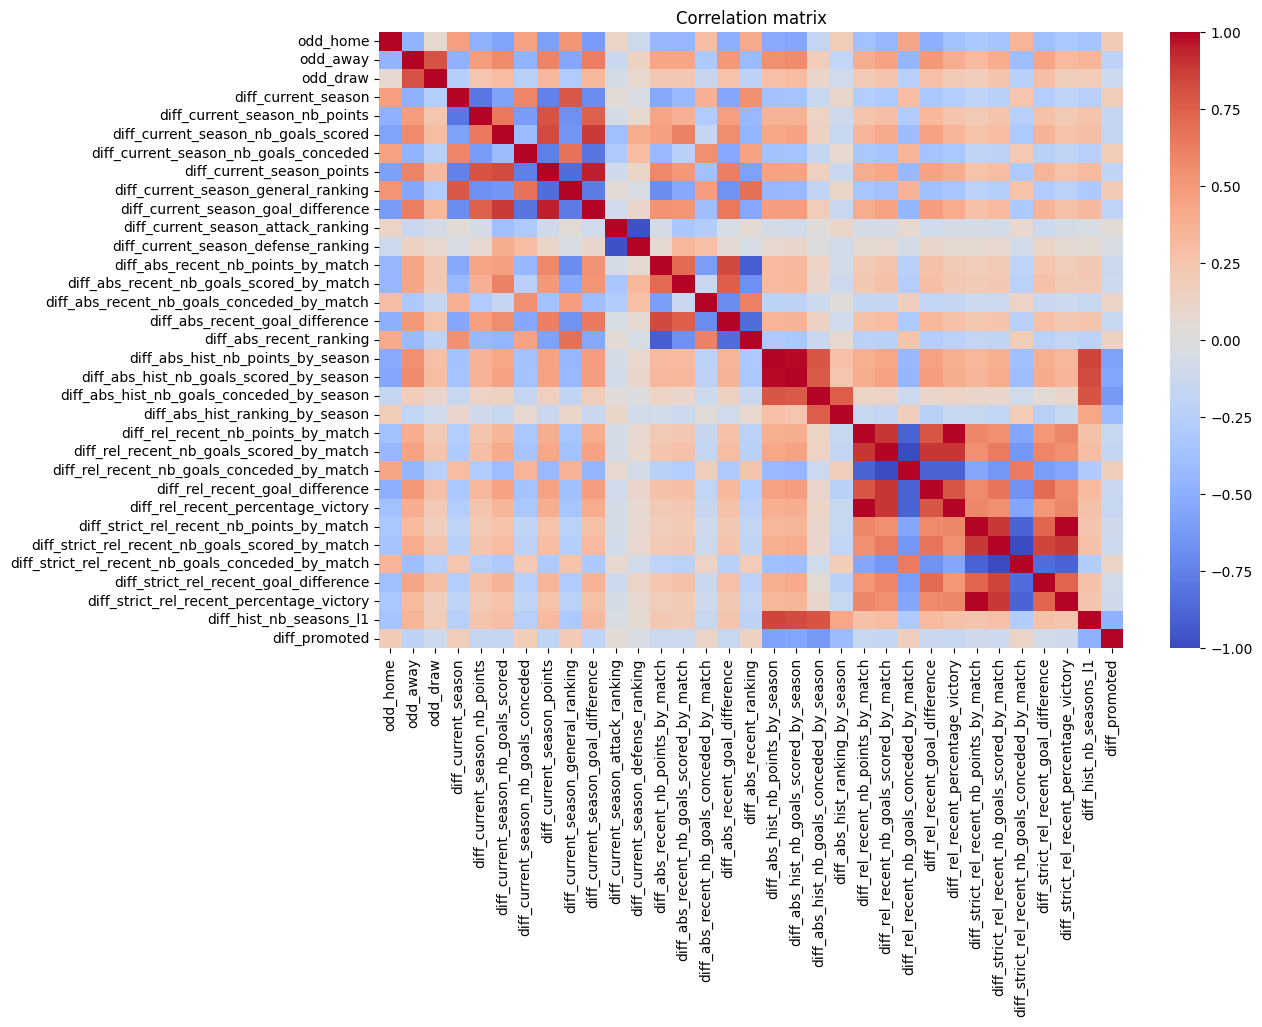

In [12]:
corr = X_train_primary.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()

In [13]:
highly_correlated_cols = find_highly_correlated_cols(X_train_primary)
highly_correlated_cols

['diff_current_season_attack_ranking',
 'diff_strict_rel_recent_nb_goals_conceded_by_match',
 'diff_strict_rel_recent_nb_points_by_match',
 'diff_rel_recent_nb_goals_conceded_by_match',
 'diff_rel_recent_percentage_victory',
 'diff_abs_hist_nb_goals_scored_by_season']

In [14]:
X_train_primary = X_train_primary.drop(columns=highly_correlated_cols)
X_test_primary = X_test_primary.drop(columns=highly_correlated_cols)

### Low variance method

In [15]:
low_variance_cols = remove_low_variance_features(X_train_primary)
low_variance_cols

[]

In [16]:
X_train_primary = X_train_primary.drop(columns=low_variance_cols)
X_test_primary = X_test_primary.drop(columns=low_variance_cols)

In [17]:
X_train_primary.columns

Index(['home', 'away', 'odd_home', 'odd_away', 'odd_draw',
       'diff_current_season', 'diff_current_season_nb_points',
       'diff_current_season_nb_goals_scored',
       'diff_current_season_nb_goals_conceded', 'diff_current_season_points',
       'diff_current_season_general_ranking',
       'diff_current_season_goal_difference',
       'diff_current_season_defense_ranking',
       'diff_abs_recent_nb_points_by_match',
       'diff_abs_recent_nb_goals_scored_by_match',
       'diff_abs_recent_nb_goals_conceded_by_match',
       'diff_abs_recent_goal_difference', 'diff_abs_recent_ranking',
       'diff_abs_hist_nb_points_by_season',
       'diff_abs_hist_nb_goals_conceded_by_season',
       'diff_abs_hist_ranking_by_season', 'diff_rel_recent_nb_points_by_match',
       'diff_rel_recent_nb_goals_scored_by_match',
       'diff_rel_recent_goal_difference',
       'diff_strict_rel_recent_nb_goals_scored_by_match',
       'diff_strict_rel_recent_goal_difference',
       'diff_strict_re

### Top K features 

In [18]:
top_k_cols = select_top_features(X_train_primary, y_train_primary)
top_k_cols

Index(['odd_home', 'odd_away', 'diff_current_season',
       'diff_current_season_nb_points', 'diff_current_season_nb_goals_scored',
       'diff_current_season_nb_goals_conceded', 'diff_current_season_points',
       'diff_current_season_general_ranking',
       'diff_current_season_goal_difference',
       'diff_abs_recent_nb_points_by_match',
       'diff_abs_recent_nb_goals_scored_by_match',
       'diff_abs_recent_goal_difference', 'diff_abs_recent_ranking',
       'diff_abs_hist_nb_points_by_season',
       'diff_rel_recent_nb_points_by_match',
       'diff_rel_recent_nb_goals_scored_by_match',
       'diff_rel_recent_goal_difference',
       'diff_strict_rel_recent_nb_goals_scored_by_match',
       'diff_strict_rel_recent_goal_difference', 'diff_hist_nb_seasons_l1'],
      dtype='object')

In [19]:
# Optional: only select these top k features
# X_train_primary = X_train_primary[top_k_cols]
# X_test_primary = X_test_primary[top_k_cols]

## Fitting

Three types of classifiers will be tested:
- logistic regression
- random forest
- XGBoost

For hyperparameters, we will fit with a GridSearch.

### Logistic regression

In [20]:
cat_cols = [config['home_column'], config['away_column']]
num_cols = X_train_primary.select_dtypes(include=['int64','float64']).columns.tolist()
    
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=5000))
])

### Random forest

In [21]:
cat_cols = [config['home_column'], config['away_column']]
num_cols = X_train_primary.select_dtypes(include=['int64','float64']).columns.tolist()
    
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=1))
])

### XGBoost

In [22]:
cat_cols = [config['home_column'], config['away_column']]
num_cols = X_train_primary.select_dtypes(include=['int64','float64']).columns.tolist()
    
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss'))
])

### Run

In [23]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_primary)

# run_grid_searches(X=X_train_primary,
#                   y=y_train_enc,
#                   param_grid_lr=config['param_grid_lr'],
#                   param_grid_rf=config['param_grid_rf'],
#                   param_grid_xgb=config['param_grid_xgb'],
#                   preprocessing_pipeline_lr=pipe_lr,
#                   preprocessing_pipeline_rf=pipe_rf,
#                   preprocessing_pipeline_xgb=pipe_xgb,
#                   outdir=config['primary_models_dir'])

## Model evaluation

In [24]:
y_test_enc = le.transform(y_test_primary)

### Logistic Regression

In [25]:
best_lr = load_model(os.path.join('..', config['primary_models_dir'], 'logistic_grid.joblib'))
metrics = evaluate_model_metrics(best_lr, X_test_primary, y_test_enc)

Model loaded from ..\models/primary\logistic_grid.joblib
Evaluation metrics:
accuracy: 0.5033
f1_macro: 0.4788
precision_macro: 0.4895
recall_macro: 0.4843


### Random Forest

In [26]:
best_rf = load_model(os.path.join('..', config['primary_models_dir'], 'rf_grid.joblib'))
metrics = evaluate_model_metrics(best_rf, X_test_primary, y_test_enc)

Model loaded from ..\models/primary\rf_grid.joblib
Evaluation metrics:
accuracy: 0.5294
f1_macro: 0.4543
precision_macro: 0.4566
recall_macro: 0.4642


### XGBoost

In [27]:
# best_xgb = load_model(os.path.join(config['primary_models_dir'], 'xgb_grid.joblib'))
# metrics = evaluate_model_metrics(best_xgb, X_test_primary, y_test_enc)

# Secondary models

Targets: knowing the probabilities of a match issue, number of goals of the two teams. There are therefore two different models: one dedicated to predict the number of goals scored by the home team, one dedicated to the number of goals scored by the away team.

## Feature engineering

Recovery of the home and away columns, providen as input of the two secondary models. Note that for each model, we recover only the performance indicators for each team, and the average of final result probabilities generated by the three primary models (these features replace the odd columns).

In [38]:
X_train.columns

Index(['home', 'away', 'odd_home', 'odd_away', 'odd_draw',
       'current_season_points_home_team', 'current_season_points_away_team',
       'current_season_general_ranking_home_team',
       'current_season_general_ranking_away_team',
       'current_season_nb_goals_scored_home_team',
       'current_season_nb_goals_scored_away_team',
       'current_season_nb_goals_conceded_home_team',
       'current_season_nb_goals_conceded_away_team',
       'current_season_goal_difference_home_team',
       'current_season_goal_difference_away_team',
       'current_season_attack_ranking_home_team',
       'current_season_attack_ranking_away_team',
       'current_season_defense_ranking_home_team',
       'current_season_defense_ranking_away_team',
       'current_season_nb_points_home_team_at_home',
       'current_season_nb_points_away_team_away',
       'current_season_home_team_ranking_at_home',
       'current_season_away_team_ranking_away',
       'current_season_nb_goals_scored_home_team

In [90]:
patterns = [
        ("_home_team_ranking_at_home", "_away_team_ranking_away"),
        ("_home_team_at_home", "_away_team_away"),
        ("_home_team", "_away_team"),
        ("_at_home", "_away"),
        ("_home", "_away")
]

home_columns = [config['home_column'], config['away_column']]
away_columns = [config['home_column'], config['away_column']]
classified_cols = set(home_columns + away_columns)

for home_suffix, away_suffix in patterns:
    home_cols_with_suffix = [c for c in X_train.columns if (c.endswith(home_suffix) and c != config['odd_home_column'] and c not in classified_cols)]
    away_cols_with_suffix = [c for c in X_train.columns if (c.endswith(away_suffix) and c != config['odd_away_column'] and c not in classified_cols)]

    home_columns += home_cols_with_suffix
    away_columns += away_cols_with_suffix

    classified_cols.update(home_cols_with_suffix + away_cols_with_suffix)

# QC test
if len(home_columns) + len(away_columns) + 1 != len(X_train.columns):
    raise ValueError(f"X_train has {len(X_train.columns)} columns, {len(home_columns) + len(away_columns) + 3} columns have been classified")

In [91]:
# Match issues probabilities

models_to_consider = [best_lr, best_rf]
name_models = ['lr', 'rf'] # in the same order

labels = le.inverse_transform(np.array((0,1,2)))
probs_df_train = pd.DataFrame()
probs_df_test = pd.DataFrame()

for i, model in enumerate(models_to_consider):
    df_model_train = pd.DataFrame(model.predict_proba(X_train_primary), columns=[f"proba_{lab}_{name_models[i]}" for lab in labels])
    probs_df_train = pd.concat([probs_df_train, df_model_train], axis=1)

    df_model_test = pd.DataFrame(model.predict_proba(X_test_primary), columns=[f"proba_{lab}_{name_models[i]}" for lab in labels])
    probs_df_test = pd.concat([probs_df_test, df_model_test], axis=1)

# Averaging issue probabilities along models
probs_df_train['proba_home'] = probs_df_train[['proba_home_lr', 'proba_home_rf']].mean(axis=1)
probs_df_train['proba_draw'] = probs_df_train[['proba_draw_lr', 'proba_draw_rf']].mean(axis=1)
probs_df_train['proba_away'] = probs_df_train[['proba_away_lr', 'proba_away_rf']].mean(axis=1)
probs_df_train = probs_df_train[['proba_home', 'proba_draw', 'proba_away']]

probs_df_test['proba_home'] = probs_df_test[['proba_home_lr', 'proba_home_rf']].mean(axis=1)
probs_df_test['proba_draw'] = probs_df_test[['proba_draw_lr', 'proba_draw_rf']].mean(axis=1)
probs_df_test['proba_away'] = probs_df_test[['proba_away_lr', 'proba_away_rf']].mean(axis=1)
probs_df_test = probs_df_test[['proba_home', 'proba_draw', 'proba_away']]

In [92]:
# X_train construction
X_train_secondary_home = X_train[home_columns]
X_train_secondary_home = pd.concat([X_train_secondary_home, probs_df_train], axis=1)

X_train_secondary_away = X_train[away_columns]
X_train_secondary_away = pd.concat([X_train_secondary_away, probs_df_train], axis=1)

# X_test construction
X_test_secondary_home = X_test[home_columns]
X_test_secondary_home = pd.concat([X_test_secondary_home, probs_df_test], axis=1)

X_test_secondary_away = X_test[away_columns]
X_test_secondary_away = pd.concat([X_test_secondary_away, probs_df_test], axis=1)